In [1]:
import numpy as np  # array operations
import pandas as pd  # time series management
from pandas_datareader import data as web  # data retrieval
import matplotlib.pyplot as plt  # standard plotting library
import seaborn as sns
sns.set()  # nicer plotting style
# put all plots in the notebook itself
%matplotlib inline

In [2]:
SPX = web.DataReader('^GSPC', data_source='yahoo', start='2005-1-1')

In [4]:
SPX.tail()  # the final five rows

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2016-05-09,2057.550049,2064.149902,2054.310059,2058.689941,3788620000,2058.689941
2016-05-10,2062.629883,2084.870117,2062.629883,2084.389893,3600200000,2084.389893
2016-05-11,2083.290039,2083.290039,2064.459961,2064.459961,3821980000,2064.459961
2016-05-12,2067.169922,2073.989990,2053.129883,2064.110107,3782390000,2064.110107
2016-05-13,2062.500000,2066.790039,2043.130005,2046.609985,3579880000,2046.609985


We want to implement a trading strategy based on simple moving averages (SMA). We work with two SMAs:
    
* short-term SMA over 42 days (SMA42)
* long-term SMA over 252 days (SMA252)

We distinguish two constellations:
    
* SMA42 > SMA252: buy signal, being long the market
* SMA42 < SMA252: sell signal, being short the market

We calculate the two SMAs as follows.

In [5]:
SPX['SMA42'] = SPX['Adj Close'].rolling(window=42).mean()
SPX['SMA252'] = SPX['Adj Close'].rolling(window=252).mean()
SPX.dropna(inplace=True)  # drop rows with NaN values

In graphical terms, we want to be long the market whenever the SMA42 line is above the SMA252 line and vice versa.

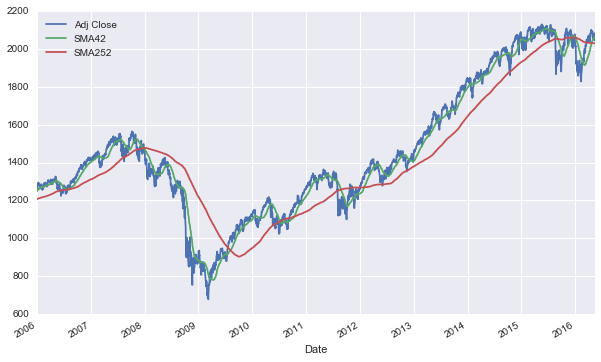

In [6]:
SPX[['Adj Close', 'SMA42', 'SMA252']].plot(figsize=(10, 6));

This need to be formalized for the calculations to come. We represent "being long the market" by 1 and "being short the market" by -1.

In [7]:
# vectorized evaluation of the trading condition/signal generation
SPX['position'] = np.where(SPX['SMA42'] > SPX['SMA252'], 1, -1)

Let us visualize the positions resulting from the signal. We start with a long position, do several re-positionings and end with a short position.

(-1.1, 1.1)

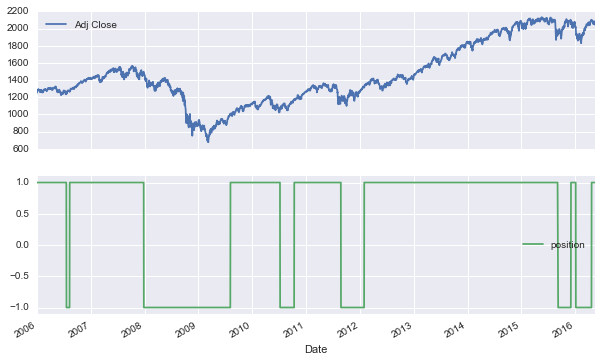

In [8]:
SPX[['Adj Close', 'position']].plot(subplots=True, figsize=(10, 6))
plt.ylim(-1.1, 1.1)  # adjust y-axis limits

# Backtesting

Let us calculate the log returns as in the first module. These are needed to judge the performance, i.e. to backtest, our SMA-based trading strategy. We call the column market since these are the market returns.

In [9]:
# vectorized calculation of log returns
SPX['market'] = np.log(SPX['Adj Close'] / SPX['Adj Close'].shift(1))

Next, we can use the market returns to derive the strategy returns in vectorized fashion. Note the shift of the position column by one day, i.e. we have entered/maintained a position yesterday and and today's returns. It now becomes clear, why 1 represents a long position and -1 a short position: we get the market return when we are long and -1 times the market return when we are short. All this makes obviously a number of simplifying assumptions (e.g. no transaction costs).

In [10]:
# vectorized calculation of strategy returns
SPX['strategy'] = SPX['position'].shift(1) * SPX['market']

Next, let us calculate the cumulative returns of the market vs. the trading strategy. This is straightforward since we work with log returns. We first calculate the cumulative sums (cumsum) and the apply the exponential function (np.exp) to the respective time series.

In [11]:
SPX[['market', 'strategy']].cumsum().apply(np.exp).tail()

,market,strategy
Date,,
2016-05-09,1.649208,1.899516
2016-05-10,1.669796,1.923229
2016-05-11,1.653830,1.904840
2016-05-12,1.653550,1.904517
2016-05-13,1.639531,1.888370


And the cumulative market vs. strategy returns visualized. As the numbers and the plot suggest, the strategy in this case outperforms the market by a considerable margin.

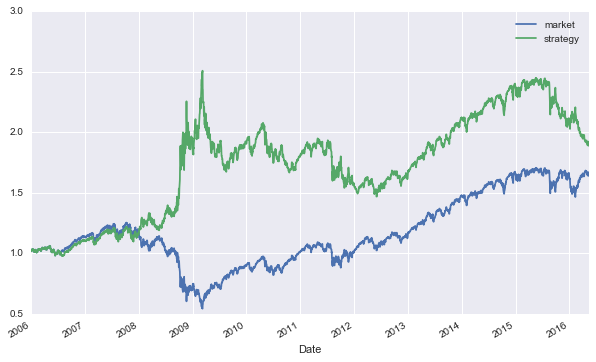

In [12]:
SPX[['market', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6));

# Risk and Return

In [13]:
arets = SPX[['market', 'strategy']].mean() * 252  # annualized returns
arets

market      0.047754
strategy    0.061403
dtype: float64

In [14]:
astds = SPX[['market', 'strategy']].std() * 252 ** 0.5  # annualized volatility
astds

market      0.206362
strategy    0.206347
dtype: float64